### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
from pprint import pprint 


# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver
from tqdm.notebook import tqdm


Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
sample_q_values = [('4-0-0', '4-2'), ('2-0-0', '2-3'), ('1-0-0', '1-4'),('0-0-0', '0-4')]    
# Tracking q-values for all possible moves from position 4 at the start of the episode
def initialise_tracking_states():
  
    for q_value in sample_q_values:
        state = q_value[0]
        action = q_value[1]
        States_track[state][action] = []
#     print(States_track)

In [5]:
States_track = collections.defaultdict(dict)
initialise_tracking_states()

In [6]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate =  0.001      
        self.epsilon = 1.0
        self.epsilon_decay = 0.001
        self.min_epsilon = 0.01
        self.max_epsilon = 1

        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets 
        input_shape = self.state_size
        model = Sequential()
        
        # Write your code here: Add layers to your neural nets       
        
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        # the output layer: output is of size num_actions
        
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state):
    # print('asdsadsadsadasdasda',state,len(state))

    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment   
        possible_actions_index,actions = env.requests(state) # Find possible action indexes and append 0
        possible_actions_index.append(0)
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # Give a random action only amongst possible action
            return random.sample(possible_actions_index,1)[0]
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            #  state = state.reshape(1, self.state_size)
            state = np.array(env.state_encod_arch1(state)).reshape(1, self.state_size)
            q_value = self.model.predict(state)
            # Give action with max q_value only amongst possible action
            return np.where(q_value[0] == np.max(np.array([q_value[0][i] for i in possible_actions_index])))[0][0]
        
        


    def append_sample(self, state, action, reward, next_state,done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state,done))

    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        # print('sadsadsadsadsadsadsad',len(self.memory) > self.batch_size,len(self.memory),self.batch_size)

        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            # print(update_input)
            actions, rewards, done = [], [], []
            # print(self.batch_size, self.state_size)

            for i in range(self.batch_size):
                # print("append done",i)
                state, action, reward, next_state, done_boolean = mini_batch[i]
                # print("$$$$",'\n',update_input[i],len(update_input[i]))
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)

                
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
            # print('$$$',done)
                
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
        

                
                
                # 4. Fit model
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    #Function to save q-value for tracking states-action pair
    def save_tracking_states(self):
        for state in States_track.keys():
            # pprint(state)
            for action in States_track[state].keys():
                # Use the model to predict the q_value of the state we are tacking.
                stateArr=state.split('-')
                # print(stateArr)
                track_state = np.array(env.state_encod_arch1([int(stateArr[0]),int(stateArr[1]),int(stateArr[2])])).reshape(1, self.state_size)

                q_value = self.model.predict(track_state)
                actions=action.split('-')
                # print('adasdasdasdasdasda',q_value)
                # Grab the q_value of the action index that we are tracking.
                # self.states_tracked.append(q_value[actions[0]][actions[1]])
                actions_q_value=q_value[0][int(actions[1])]
                States_track[state][action].append(actions_q_value)


    def save(self, name):
        self.model.save(name)

In [8]:
# Episodes = 5000

In [9]:
Episode_length = 24*30 #30 days before which car has to be recharged
Episodes = 25000

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()
state = env.state_init
state_encoded = env.state_encod_arch1(state)
# print(len(action_space))

# Invoke agent class

agent = DQNAgent(action_size=len(action_space), state_size=len(state_encoded))

# to store rewards in each episode

rewards_per_episode, episodes = [], []


### DQN block

In [10]:
tracked_scores =[]
start_time = time.time()
for episode in tqdm(range(Episodes)):
# for episode in range(Episodes):

    # Write code here
    terminal_state = False
    score = 0

    # Call the environment
    env = CabDriver()
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state  = env.state_init
    # print("Initial State is ",state)
    
    total_time = 0 


    #Call the DQN agent
    
    
    while not terminal_state:
        
        # Write your code here

        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(state)

        # 2. Evaluate your reward and next state
        reward = env.reward_func(state, env.action_space[action], Time_matrix)
        next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)


        # 3. Total time driver rode in this episode
        
        total_time += ride_time
        if (total_time > Episode_length):
            # if ride does not complete in stipu;ated time skip
            # it and move to next episode.
            terminal_state = True
        
        else:
            
            # 4. Append the experience to the memory
            
            agent.append_sample(state, action, reward, next_state, terminal_state)
            
            # 5. Train the model by calling function agent.train_model
            
            agent.train_model()
            
            # 6. Keep a track of rewards, Q-values, loss
            
            score += reward
            state = next_state

    # store total reward obtained in this episode
    
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    if agent.epsilon > agent.min_epsilon:
        agent.epsilon=agent.min_epsilon + (agent.max_epsilon - agent.min_epsilon) * np.exp(-agent.epsilon_decay*episode)

    # every 500 episodes:
    if (episode == 0 or ((episode) % 500) == 0 ):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    ##############################
    ########################
    ###################
    if (episode % 50 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    
    tracked_scores.append(score)

    if(episode % 100 == 0):
        agent.save(name="model_weights.pkl")
    
elapsed_time = time.time() - start_time
print('Elapsed Time: ',elapsed_time)

        


episode 0, reward -213.0, memory_length 117, epsilon 1.0 total_time 726.0
episode 500, reward 314.0, memory_length 2000, epsilon 0.6104653531155071 total_time 729.0
episode 1000, reward 969.0, memory_length 2000, epsilon 0.3742006467597279 total_time 721.0
episode 1500, reward 857.0, memory_length 2000, epsilon 0.23089885854694553 total_time 728.0
episode 2000, reward 1344.0, memory_length 2000, epsilon 0.1439819304042466 total_time 726.0
episode 2500, reward 1410.0, memory_length 2000, epsilon 0.0912641486376598 total_time 722.0
episode 3000, reward 1603.0, memory_length 2000, epsilon 0.05928919768418531 total_time 723.0
episode 3500, reward 1304.0, memory_length 2000, epsilon 0.039895409588095315 total_time 721.0
episode 4000, reward 1608.0, memory_length 2000, epsilon 0.028132482499846838 total_time 722.0
episode 4500, reward 1714.0, memory_length 2000, epsilon 0.02099790657285988 total_time 723.0
episode 5000, reward 1772.0, memory_length 2000, epsilon 0.016670567529094613 total_t

In [11]:
States_track

defaultdict(dict,
            {'4-0-0': {'4-2': [0.0,
               1074.6757,
               1618.9646,
               1991.6422,
               2428.568,
               2197.2463,
               2325.7698,
               2338.0398,
               2391.8596,
               2623.7188,
               2332.79,
               2405.8362,
               2651.9287,
               2543.802,
               2533.6416,
               2529.3442,
               2647.9512,
               2550.773,
               2556.5322,
               2593.2212,
               2489.6,
               2688.6333,
               2533.162,
               2604.8494,
               2596.867,
               2665.6453,
               2626.1648,
               2761.3855,
               2846.0771,
               2776.3967,
               2785.1538,
               2540.3203,
               2823.5266,
               2727.6606,
               2692.7388,
               2710.0808,
               2805.9043,
               2826.

### Tracking Convergence

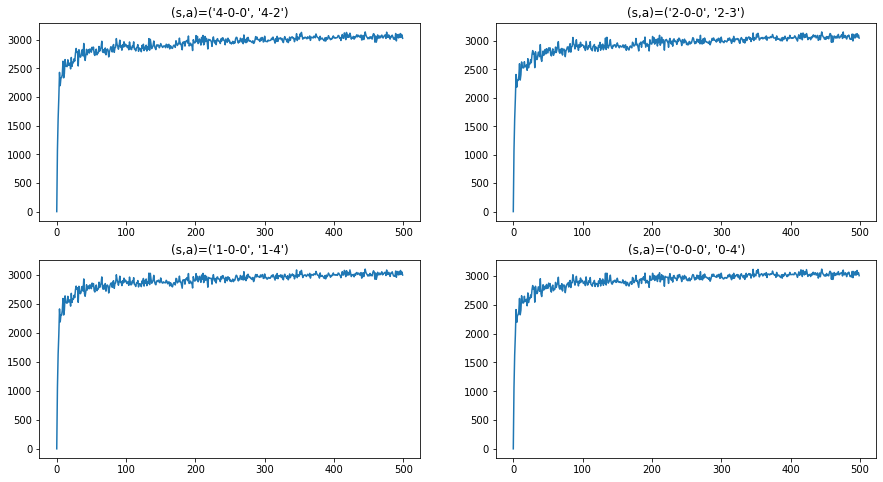

In [12]:
# Write the code for plotting the graphs for state-action pairs tracked
plt.figure(0, figsize=(15,8))

for index in range(len(sample_q_values)):
    
    x_axis = np.asarray(range(0, len(States_track[sample_q_values[index][0]][sample_q_values[index][1]])))
#     print("(s,a)=" + str(sample_q_values[index]))
   
    plt.subplot(2,2,index+1)
    plt.plot(x_axis,np.asarray(States_track[sample_q_values[index][0]][sample_q_values[index][1]]))
    plt.title("(s,a)=" + str(sample_q_values[index]))
plt.show()


In [13]:
# tracked_scores

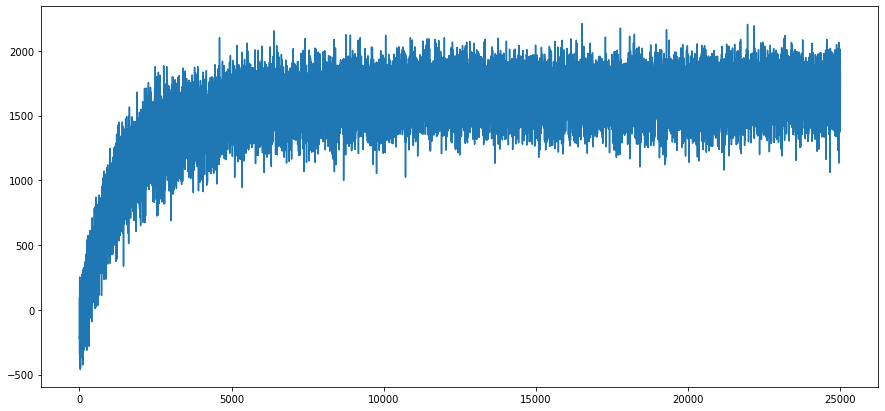

In [17]:
# Ploting Rewards along the episodes
plt.figure(0, figsize=(15,7))
plt.plot(episodes,tracked_scores)

### The above graph shows that reward is increasing and starts stabilizing between 8000-10000 episodes.

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

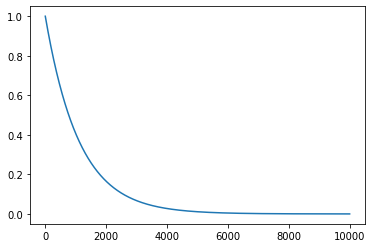

In [15]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))
#     epsilon.append(agent.min_epsilon + (agent.max_epsilon - agent.min_epsilon) * np.exp(-agent.epsilon_decay*episode))
plt.plot(time, epsilon)
plt.show()

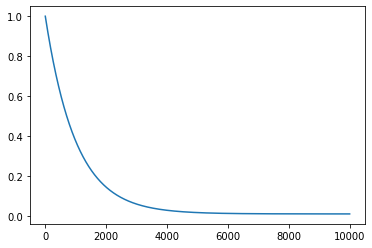

In [20]:
# Custom Epsilon fucntion used in above DQN
time = np.arange(0,10000)
epsilon2 = []
for i in range(0,10000):
    if agent.epsilon > agent.min_epsilon:
        epsilon2.append(agent.min_epsilon + (agent.max_epsilon - agent.min_epsilon) * np.exp(-agent.epsilon_decay*i))
plt.plot(time, epsilon2)
plt.show()